In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import ot
import cvxpy as cp

# Supplementary Packages
import scipy.stats as stats
import seaborn as sns
#import scipy.special as sps
import time as t

## Functions

In [2]:
def baryc_proj(source, target, method):
    
    n1 = source.shape[0]
    n2 = target.shape[0]   
    p = source.shape[1]
    a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2
    
    M = ot.dist(source, target)
    M = M.astype('float64')
    M /= M.max()
    
    if method == 'emd':
        OTplan = ot.emd(a_ones, b_ones, M, numItermax = 1e7)
        
    elif method == 'entropic':
        OTplan = ot.bregman.sinkhorn_stabilized(a_ones, b_ones, M, reg = 5*1e-3)
    
    # initialization
    OTmap = np.empty((0, p))

    for i in range(n1):
        
        # normalization
        OTplan[i,:] = OTplan[i,:] / sum(OTplan[i,:])
    
        # conditional expectation
        OTmap = np.vstack([OTmap, (target.T @ OTplan[i,:])])
    
    OTmap = np.array(OTmap)
    
    return(OTmap)

In [3]:
def DSCreplicationV2(target, controls, method = 'emd'):
    
    n = target.shape[0]
    d = target.shape[1]
    J = len(controls)
    S = np.mean(target)*n*d*J #Stabilizer: to be used in optimization
    
    
    # Barycentric Projection
    G_list = []
    proj_list = []
    for i in range(len(controls)):
        temp = baryc_proj(target, controls[i], method)
        G_list.append(temp)
        proj_list.append(temp - target)
    
    
    # Obtain optimal weights
    mylambda = cp.Variable(J)

    objective = cp.Minimize(
                    cp.sum(
                    cp.sum(
                    cp.sum([a*b for a,b in zip(mylambda, proj_list)])**2))/n
                    )
    
    constraints = [mylambda >= 0, mylambda <= 1, cp.sum(mylambda) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    weights = mylambda.value
    replication = sum([a*b for a,b in zip(weights, G_list)])
    
    
    return(weights, replication)

## Medicare Data

In [4]:
def read_medicaid(file_name, columns, sample = True):
    
    df = pd.read_csv(file_name)[columns]
    
    if sample:
        df = df.sample(1500, random_state = 31)
    
    return(np.array(df))

In [5]:
import os, glob
medidata = []

columns1 = ['HINSCAID','EMPSTAT','UHRSWORK','INCWAGE']
for file in sorted(glob.glob("workingData/medicaid/*.csv")):
    medidata.append(read_medicaid(file, columns1))

medidata.insert(0, medidata.pop(5)) # Move Montana to front of list
medi_target = medidata[0]
medi_controls = medidata[1:]


#for counterfactual exercise
mt_years = read_medicaid("workingData/medicaid/MT.csv", ['YEAR'])

### Test Run

In [6]:
weightsm, replicationm = DSCreplicationV2(medi_target, medi_controls)

# round integer columns
replicationm[:,0:2] = replicationm[:,0:2].round(decimals = 0).astype('int64')

In [7]:
medi_target[0:5,:]

array([[ 1.        ,  1.        ,  2.72129543,  8.20193435],
       [ 1.        ,  1.        ,  4.98086314, 13.38312636],
       [ 1.        ,  1.        ,  4.61313836, 11.5696838 ],
       [ 1.        ,  1.        ,  3.60549785, 10.12021054],
       [ 1.        ,  1.        ,  3.85439389, 10.87993221]])

In [8]:
replicationm[0:5,:]

array([[ 1.        ,  1.        ,  2.73017999,  8.30293574],
       [ 1.        ,  1.        ,  4.72969576, 13.066235  ],
       [ 1.        ,  1.        ,  4.60684693, 11.63850207],
       [ 1.        ,  1.        ,  3.63609741, 10.21458135],
       [ 1.        ,  1.        ,  3.93653063, 10.96411101]])

In [9]:
weightsm

array([ 1.83539903e-01, -6.28353775e-21, -3.98446732e-20, -1.37940363e-20,
        1.74426128e-01, -3.37975241e-20,  9.88190280e-03,  5.13105129e-01,
       -3.67889695e-21,  7.92196942e-22,  1.19046937e-01, -2.01338829e-20])

## RESULTS

### HINSCAID

In [10]:
1500 - sum(medi_target[:,0] == replicationm[:,0]) ## number of misses

16

### EMPSTAT

In [11]:
1500 - sum(medi_target[:,1] == replicationm[:,1]) ## number of misses

15

### UHRSWORK

(array([  5.,   4.,  14.,  70., 203., 338., 427., 321., 100.,  18.]),
 array([-1.07880966, -0.37203255,  0.33474455,  1.04152166,  1.74829877,
         2.45507588,  3.16185299,  3.86863009,  4.5754072 ,  5.28218431,
         5.98896142]),
 <BarContainer object of 10 artists>)

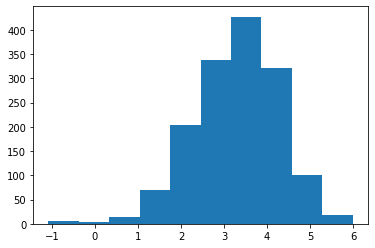

In [12]:
plt.hist(medi_target[:,2])

(array([  5.,   8.,  22., 109., 238., 340., 384., 290.,  87.,  17.]),
 array([-0.36079492,  0.2618372 ,  0.88446932,  1.50710143,  2.12973355,
         2.75236567,  3.37499779,  3.9976299 ,  4.62026202,  5.24289414,
         5.86552625]),
 <BarContainer object of 10 artists>)

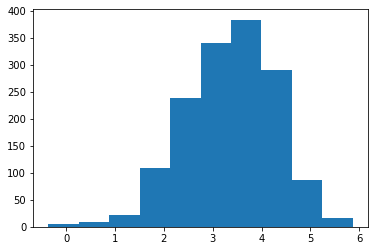

In [13]:
plt.hist(replicationm[:,2])

### INCWAGE

(array([  3.,  10.,  16.,  46., 154., 372., 462., 332.,  88.,  17.]),
 array([ 3.73766962,  4.72704941,  5.7164292 ,  6.70580899,  7.69518878,
         8.68456857,  9.67394836, 10.66332815, 11.65270794, 12.64208773,
        13.63146752]),
 <BarContainer object of 10 artists>)

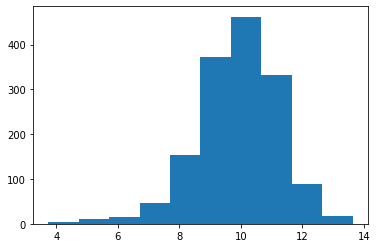

In [14]:
plt.hist(medi_target[:,3])

(array([  2.,   1.,  11.,  36., 111., 341., 488., 378., 118.,  14.]),
 array([ 3.48625221,  4.50048859,  5.51472497,  6.52896135,  7.54319773,
         8.55743411,  9.57167049, 10.58590687, 11.60014325, 12.61437963,
        13.62861601]),
 <BarContainer object of 10 artists>)

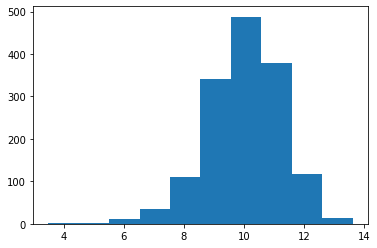

In [15]:
plt.hist(replicationm[:,3])

## Counterfactual Data

In [16]:
def read_medicaid2(file_name, columns, sample = True):
    
    df = pd.read_csv(file_name)[columns]
    
    if sample:
        df = df.sample(7775, random_state = 31) #7775 is minimum data size
    
    return(np.array(df)) 

In [17]:
postintv = []
import glob

# check path
for file in sorted(glob.glob("workingData/medicaid/Counterfactual/*.csv")):
    postintv.append(read_medicaid2(file, columns1))

postintv.insert(0, postintv.pop(5)) # Move Montana to front of list(why is mt 12?)
post_target = postintv[0]
post_controls = postintv[1:]

mt_years = read_medicaid2("workingData/medicaid/Counterfactual/MT_post.csv", ['YEAR'])

In [18]:
post_replication = sum([a*b for a,b in zip(weightsm, post_controls)])

In [48]:
post_replication[:,0:2] = post_replication[:,0:2].round(decimals = 0).astype('int64')

### HINSCAID

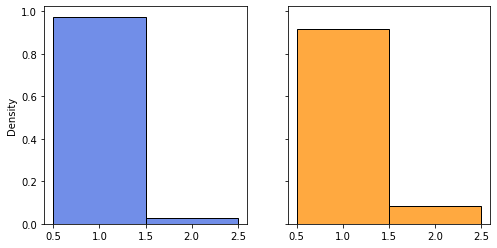

In [49]:
fig, axes = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)
sns.histplot(post_replication[:,0], ax = axes[0], discrete = True, stat = 'density', color = 'royalblue')
sns.histplot(post_target[:,0], ax = axes[1], discrete = True, stat = 'density', color = 'darkorange')

plt.savefig('plots/hinscaid_sep.png')

### EMPSTAT

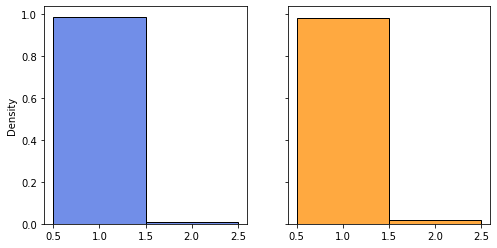

In [50]:
fig, axes = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)
sns.histplot(post_replication[:,1], ax = axes[0], discrete = True, stat = 'density', color = 'royalblue')
sns.histplot(post_target[:,1], ax = axes[1], discrete = True, stat = 'density', color = 'darkorange')

plt.savefig('plots/empstat_sep.png')

### UHRSWORK

In [51]:
#plt.hist(post_replication[:,2])

In [52]:
#plt.hist(post_target[:,2])

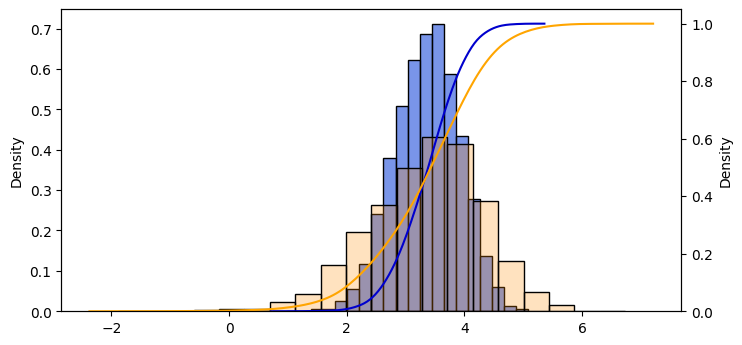

In [53]:
fig, axes = plt.subplots(figsize=(8,4), dpi=100)
ax3 = axes.twinx()

sns.histplot(post_replication[:,2], bins = 20, color = 'royalblue', ax = axes, alpha = 0.7, stat = 'density')
sns.histplot(post_target[:,2], bins = 20, ax = axes, color = 'darkorange', alpha = 0.25, stat = 'density')

sns.kdeplot(post_replication[:,2], cumulative = True, ax = ax3, color = 'mediumblue')
sns.kdeplot(post_target[:,2], cumulative = True, color = 'orange')

plt.savefig('plots/uhrswork_imposed.png')
plt.show()


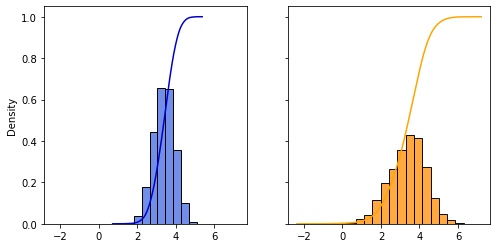

In [54]:
fig, axes = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)
sns.histplot(post_replication[:,2], bins = 10, ax = axes[0], color = 'royalblue', stat = 'density')
sns.kdeplot(post_replication[:,2], cumulative = True, ax = axes[0], color = 'mediumblue')

sns.histplot(post_target[:,2], bins = 20, ax = axes[1], color = 'darkorange', stat = 'density')
sns.kdeplot(post_target[:,2], cumulative = True, ax = axes[1], color = 'orange')

plt.savefig('plots/uhrswork_sep.png')

### INCWAGE

In [55]:
#plt.hist(post_replication[:,3])

In [56]:
#plt.hist(post_target[:,3])

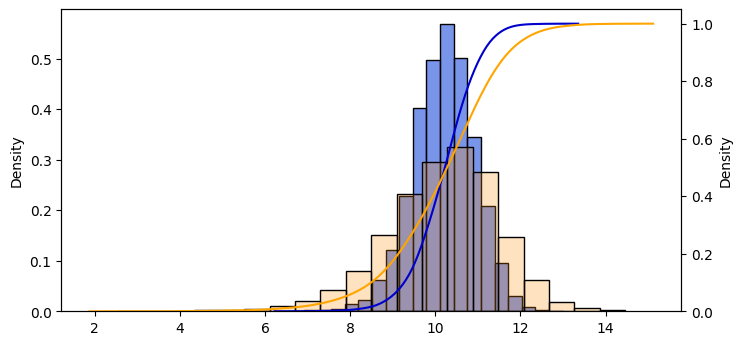

In [57]:
fig, axes = plt.subplots(figsize=(8,4), dpi=100)
ax3 = axes.twinx()

sns.histplot(post_replication[:,3], bins = 20, color = 'royalblue', ax = axes, alpha = 0.7, stat = 'density')
sns.histplot(post_target[:,3], bins = 20, ax = axes, color = 'darkorange', alpha = 0.25, stat = 'density')

sns.kdeplot(post_replication[:,3], cumulative = True, ax = ax3, color = 'mediumblue')
sns.kdeplot(post_target[:,3], cumulative = True, color = 'orange')

plt.savefig('plots/incwage_imposed.png')
plt.show()


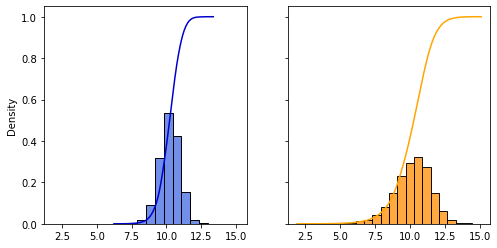

In [58]:
fig, axes = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)
sns.histplot(post_replication[:,3], bins = 10, ax = axes[0], color = 'royalblue', stat = 'density')
sns.kdeplot(post_replication[:,3], cumulative = True, ax = axes[0], color = 'mediumblue')

sns.histplot(post_target[:,3], bins = 20, ax = axes[1], color = 'darkorange', stat = 'density')
sns.kdeplot(post_target[:,3], cumulative = True, ax = axes[1], color = 'orange')

plt.savefig('plots/incwage_sep.png')

<AxesSubplot:ylabel='Density'>

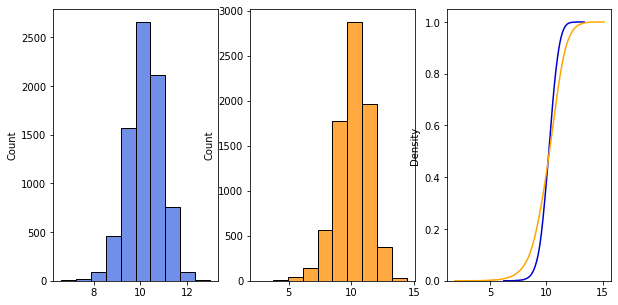

In [59]:
## TEST

fig2, axes2 = plt.subplots(1,3, figsize = (10,5))
sns.histplot(post_replication[:,3], bins = 10, ax = axes2[0], color = 'royalblue')
sns.kdeplot(post_replication[:,3], cumulative = True, ax = axes2[2], color = 'mediumblue')


sns.histplot(post_target[:,3], bins = 10, ax = axes2[1], color = 'darkorange')
sns.kdeplot(post_target[:,3], cumulative = True, ax = axes2[2], color = 'orange')

* high contrast color scheme